In [6]:
import numpy as np
import pandas as pd
import sqlite3

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

from twitter_scraper import Scraper

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [2]:
options = Options()
options.add_argument("--window-size=1920,1200")

# the line below if for preventing window closing
# options.headless = True

DRIVER_PATH = 'chromedriver'
driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)

# init
books = {"Title": [],
         "Price": [],
         "Rating": [],
         "Availability": [],
         "Image URL": []}
number = {"One": 1, "Two": 2, "Three": 3, "Four": 4, "Five": 5}

# page loading for each page
for p in range (1, 50+1):
    driver.get("https://books.toscrape.com/catalogue/page-" + str(p) + ".html")

    # data scrapping for each item of the page
    for i in range (1, 20+1):
        path = "/html/body/div/div/div/div/section/div[2]/ol/li[" + str(i) + "]/article/"
        title = driver.find_element(By.XPATH, path + 'h3/a')
        price = driver.find_element(By.XPATH, path + 'div[2]/p[1]')
        stock = driver.find_element(By.XPATH, path + 'div[2]/p[2]')
        stars = driver.find_element(By.XPATH, path + 'p')
        image = driver.find_element(By.XPATH, path + 'div[1]/a/img')
        
        # turning star rating text into number
        stars = number[stars.get_attribute("class").split()[1]]
    
        # putting values in the dictionary
        books["Title"].append(title.get_attribute("title"))
        books["Price"].append(price.text.lstrip("£"))
        books["Rating"].append(stars)
        books["Availability"].append(stock.text)
        books["Image URL"].append(image.get_attribute("src"))

# dict -> dataframe
df_books = pd.DataFrame(books)
print(df_books)

# saving dataframe into csv
df_books.to_csv('books.csv')
# saving dataframe into db
conn = sqlite3.connect('books.db')
c = conn.cursor()
conn.commit()
c.execute('CREATE TABLE IF NOT EXISTS books (title text, price float, rating int, availability text, image_url text)')
df_books.to_sql('books', conn, if_exists='replace', index = True)

driver.quit()
conn.close()

                                                 Title  Price  Rating  \
0                                 A Light in the Attic  51.77       3   
1                                   Tipping the Velvet  53.74       1   
2                                           Soumission  50.10       1   
3                                        Sharp Objects  47.82       4   
4                Sapiens: A Brief History of Humankind  54.23       5   
..                                                 ...    ...     ...   
995  Alice in Wonderland (Alice's Adventures in Won...  55.53       1   
996   Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)  57.06       4   
997  A Spy's Devotion (The Regency Spies of London #1)  16.97       5   
998                1st to Die (Women's Murder Club #1)  53.98       1   
999                 1,000 Places to See Before You Die  26.08       5   

    Availability                                          Image URL  
0       In stock  https://books.toscrape.com/media/ca

In [13]:
booktweet = []
bookqueries = ["the Art of War Sun Tzu", "the Song of Achille",
               "Batman: the Dark Night Returns", "the Picture of Dorian Gray", "the Book Thief"]
bookcsv = ["suntzu", "achille", "batman", "gray", "thief"]

# The tweets for the Art of War will be saved in tweetssuntzu.csv,
# those for the Song of Achille will be saved in tweetsachille.csv, and so on...
for i in range (len(bookqueries)):
    print(bookqueries[i])
    booktweet = Scraper(format="csv")
    booktweet.scrape(query=bookqueries[i], language="fr",
                     results_count=1000, filepath="tweets" + bookcsv[i] + ".csv",
                     since="2022-06-01")

the Art of War Sun Tzu
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 tweets scraped
600 tweets scraped
700 tweets scraped
800 tweets scraped
900 tweets scraped
1000 tweets scraped
Final save
the Song of Achille
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 tweets scraped
600 tweets scraped
700 tweets scraped
800 tweets scraped
900 tweets scraped
1000 tweets scraped
Final save
Batman: the Dark Night Returns
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 tweets scraped
600 tweets scraped
700 tweets scraped
800 tweets scraped
900 tweets scraped
1000 tweets scraped
Final save
the Picture of Dorian Gray
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped
500 tweets scraped
600 tweets scraped
700 tweets scraped
800 tweets scraped
900 tweets scraped
1000 tweets scraped
Final save
the Book Thief
100 tweets scraped
200 tweets scraped
300 tweets scraped
400 tweets scraped


the Art of War Sun Tzu


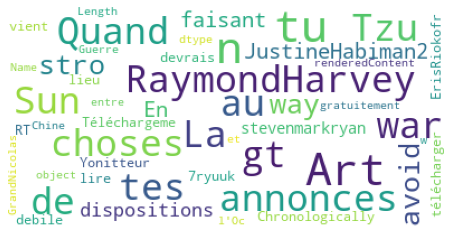

the Song of Achille


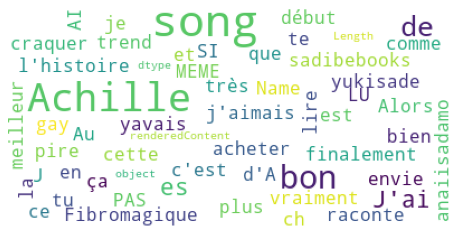

Batman: the Dark Night Returns


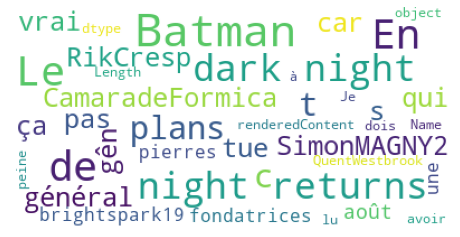

the Picture of Dorian Gray


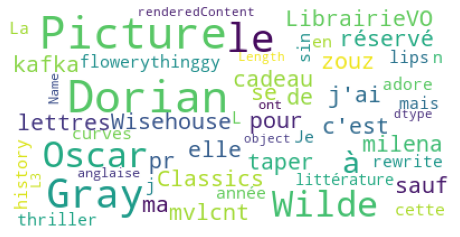

the Book Thief


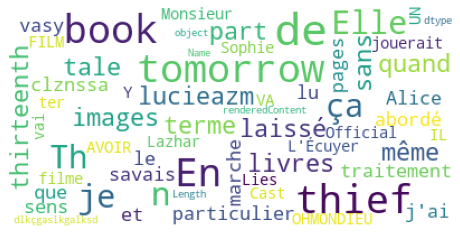

In [21]:
mpl.rcParams['figure.figsize']=(8.0,6.0)
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1 

# I don't know what stopwords is to be honest
stopwords = set(STOPWORDS)

for i in range (len(bookqueries)):
    # some lines return a parse error, skipping them...
    # also needing to re-specify separator because it's dumb
    data = pd.read_csv("tweets" + bookcsv[i] + ".csv", on_bad_lines='skip', sep='|')

    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data['renderedContent']))

    print(bookqueries[i])
    print(wordcloud)
    fig = plt.figure(1)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    fig.savefig("wc_tweets" + bookcsv[i] + ".png", dpi=900)